In [1]:
import pickle
with open("vonMisesData_100neurons.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [2]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)))
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [4]:

t0 = time.time();
# Train model with first environment
NTrain = 90
NTest = 10
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    for k in range(NTrain) :
        TrainingData[w].append(BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins))
t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  0.4883999824523926


In [5]:
[r,c] = TrainingData[w][0].shape
StackedTrainingData = np.array((r,c))
TrainingSequenceLengths = []


for idx in range(len(TrainingData[0])) :
    #l = np.random.random_integers(r/2,r)
    l = r
    TrainingSequenceLengths.append(l)

    if (idx == 0) :
        StackedTrainingData = TrainingData[0][idx][0:l,:]
    else :
        StackedTrainingData = np.vstack((StackedTrainingData,TrainingData[0][idx][0:l,:]))


In [14]:
# Compare different numbers of states
DifferentStateNumberModels = []
NStates = [8,16,24,32,64]
t0 = time.time();
for n in NStates :
    model = hmm.PoissonHMM(n_components=n, n_iter=100, tol=1e-4, init_params='smt')
    DifferentStateNumberModels.append(model)

for idx in range(len(NStates)) :
    t1 = time.time();
    # Build an HMM instance and set parameters
    DifferentStateNumberModels[idx].fit(StackedTrainingData, lengths=TrainingSequenceLengths)
    t2 = time.time();
    print(t2-t1)
t3 = time.time();
print(t3-t0) # ~120 s total

2.694993019104004
16.57834792137146
33.136630058288574
41.75716686248779
123.44310283660889
217.61224007606506


In [9]:
def ArrangeTransitionMatrix(tmat, means) :
    [NStates, _] = tmat.shape
    new_order = [0]
    rem_states = np.arange(1,NStates).tolist()
    cs = 0

    for ii in np.arange(0,NStates-1):
        nstilde = np.argmax(tmat[cs,rem_states])
        ns = rem_states[nstilde]
        rem_states.remove(ns)
        cs = ns
        new_order.append(cs)

    tmatnew = tmat[:, new_order][new_order]
    meanmat = means[new_order,:]
    return [tmatnew, meanmat]

In [10]:
[newtmat, newmeans] = ArrangeTransitionMatrix(DifferentStateNumberModels[0].transmat_, DifferentStateNumberModels[0].means_)

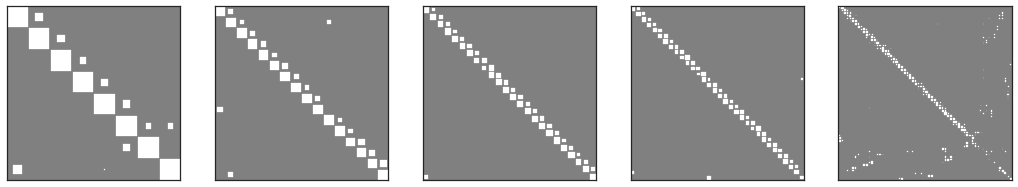

In [15]:
from hinton import hinton
f, axarr = plt.subplots(1,len(NStates))
for idx in range(len(NStates)) :
    plt.sca(axarr[idx])
    [newtmat, newmeans] = ArrangeTransitionMatrix(DifferentStateNumberModels[idx].transmat_, DifferentStateNumberModels[idx].means_)
    hinton(newtmat.T)



In [ ]:
DifferentStateNumberSequenceLL = []
t1 = time.time();
for idx in range(len(NStates)) :
    DifferentStateNumberSequenceLL.append(np.zeros(NTest))
    
for idx in range(len(NStates)) :
    for i in range(NTest) :
        DifferentStateNumberSequenceLL[idx][i] = DifferentStateNumberModels[idx].score(BinSpikeRasters(SpikeRasters[0][NTrain + i]))
    t2 = time.time();
    print(t2-t1)
    
meanLL = []
for ll in DifferentStateNumberSequenceLL:
    meanLL.append(np.mean(ll))
    
print(meanLL)